In [1]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [ ]:
def load_dataset(dataset_path):
    dataset = pd.read_csv(dataset_path, sep=";")
    return dataset


In [ ]:
def plot_confusion_matrix(y_test, y_pred, labels):
    cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Matrice de confusion')
    plt.xlabel('Labels prédits')
    plt.ylabel('Labels réels')
    plt.show()

def plot_precision_by_label(y_test, y_pred, labels):
    accuracies = (y_test.values.argmax(axis=1) == y_pred.argmax(axis=1)).mean(axis=0)
    plt.figure(figsize=(10, 6))
    plt.bar(labels, accuracies)
    plt.title('Précision par label')
    plt.xlabel('Labels')
    plt.ylabel('Précision')
    plt.xticks(rotation=90)
    plt.show()

def plot_roc_curve(y_test, y_pred, labels):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(labels)):
        fpr[i], tpr[i], _ = roc_curve(y_test.values[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 10))
    for i in range(len(labels)):
        plt.plot(fpr[i], tpr[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbes ROC')
    plt.legend()
    plt.show()

def print_classification_report(y_test, y_pred, labels):
    print("\nRapport de classification :")
    print(classification_report(y_test, y_pred, target_names=labels))

def evaluate_model(pipeline, X_test, y_test, labels):
    y_pred = pipeline.predict(X_test)
    
    print_classification_report(y_test, y_pred, labels)

    plot_confusion_matrix(y_test, y_pred, labels)

    plot_precision_by_label(y_test, y_pred, labels)

    plot_roc_curve(y_test, y_pred, labels)


In [ ]:
dataset_path = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/text/bow_text_intention_detector.csv"
dataset = load_dataset(dataset_path)

labels = [label for label in dataset.columns if label != 'sentence']
X = dataset['sentence']
y = dataset[labels]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', OneVsRestClassifier(MultinomialNB()))
])

param_grid = {
    'vectorizer__min_df': [1, 2, 3],            # minimum document frequency
    'vectorizer__max_df': [0.9, 1.0],           # maximum document frequency
    'vectorizer__ngram_range': [(1, 1)],         # Unigram (1-gram)
    'classifier__estimator__alpha': [0.1, 1.0, 10],  # Naive Bayes smoothing parameter
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

print("Lancement de l'hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)
print(f"Meilleure précision sur le train set : {grid_search.best_score_}")

best_model = grid_search.best_estimator_


Lancement de l'hyperparameter tuning...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Meilleurs paramètres trouvés :
{'classifier__estimator__alpha': 0.1, 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1)}
Meilleure précision sur le train set : 0.8952771088039516



Rapport de classification :


C:\Users\vikne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

   is_correct       0.91      1.00      0.95     78698
is_not_french       0.99      1.00      0.99     77179
  is_not_trip       0.94      0.91      0.92     78404
   is_unknown       1.00      0.83      0.91     78424

    micro avg       0.95      0.93      0.94    312705
    macro avg       0.96      0.93      0.94    312705
 weighted avg       0.96      0.93      0.94    312705
  samples avg       0.91      0.92      0.91    312705



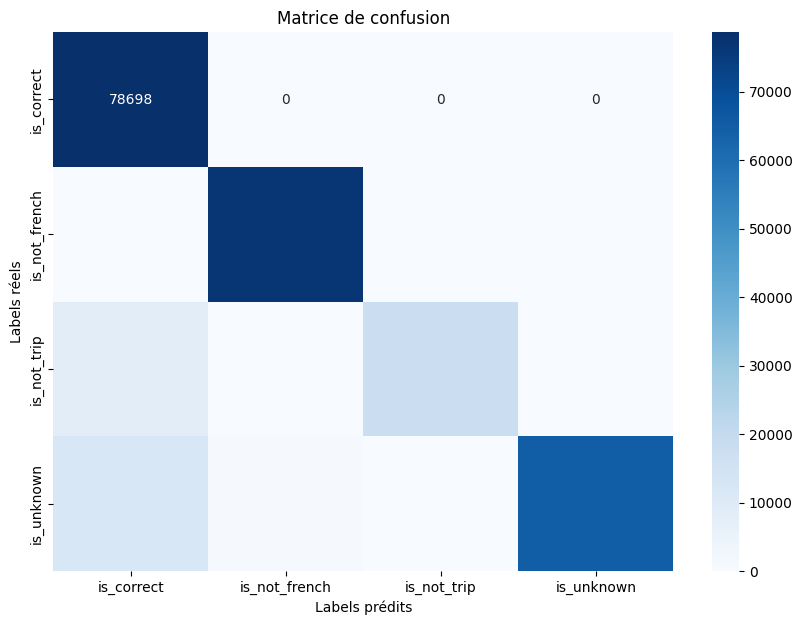

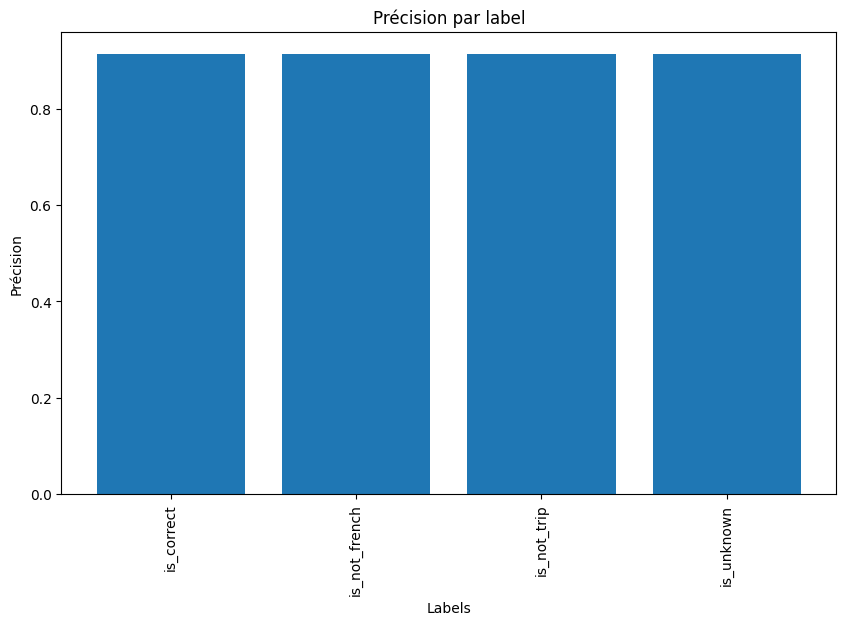

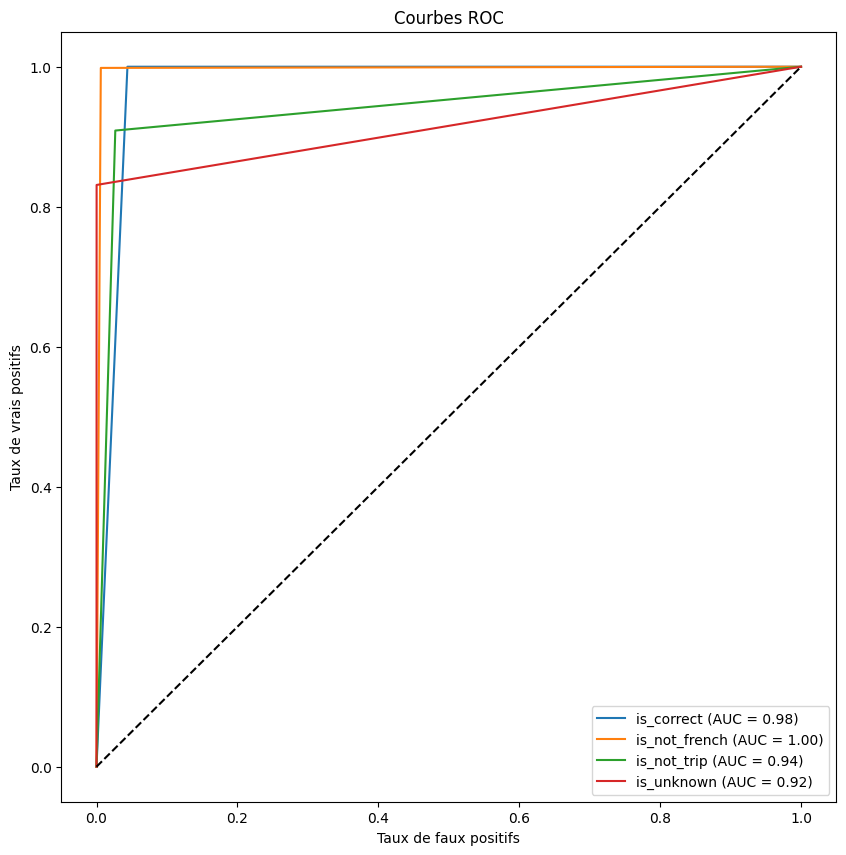

In [ ]:
evaluate_model(best_model, X_test, y_test, labels)

In [ ]:
texts = [
    "Je vais à la boulangerie acheter du pain",
    "I need to go from London to Paris",
    "Je voudrais partir de Paris et aller à Nice",
    "Find me a route from Berlin to Munich",
    "Je souhaite aller à l'aéroport de Roissy",
    "How do I get from the station to the airport?",
    "Peux-tu m'indiquer le chemin du musée au parc?",
    "Take me from Times Square to Central Park",
    "Je suis à Bordeaux, je veux aller à Lyon",
    "Je veux partir de la Gare Saint-Lazare vers Montparnasse",
    "I want to travel from New York to Los Angeles",
    "Comment aller de la plage à la gare ?",
    "I would like to travel from the hotel to the conference center",
    "Aidez-moi à trouver un trajet de Paris à Barcelone",
    "Donne-moi un itinéraire de la Tour Eiffel à Notre-Dame",
    "Trouve un itinéraire pour aller de Marseille à Toulon",
    "J'aimerais partir de la gare de Lyon vers la gare de Montparnasse",
    "I'm looking for directions from the airport to the city center",
    "J'ai besoin d'un itinéraire entre le centre-ville et le musée d'Orsay",
    "Voyagez de Paris à Sannois"
]

predictions = best_model.predict(texts)

for text, prediction in zip(texts, predictions):
    print(f"Texte : {text}")
    print(f"Prédiction : {prediction}")
    print("-" * 80)


Texte : Je vais à la boulangerie acheter du pain
Prédiction : [0 0 1 0]
--------------------------------------------------------------------------------
Texte : I need to go from London to Paris
Prédiction : [0 1 1 0]
--------------------------------------------------------------------------------
Texte : Je voudrais partir de Paris et aller à Nice
Prédiction : [1 0 0 0]
--------------------------------------------------------------------------------
Texte : Find me a route from Berlin to Munich
Prédiction : [0 1 1 0]
--------------------------------------------------------------------------------
Texte : Je souhaite aller à l'aéroport de Roissy
Prédiction : [1 0 0 0]
--------------------------------------------------------------------------------
Texte : How do I get from the station to the airport?
Prédiction : [0 1 1 0]
--------------------------------------------------------------------------------
Texte : Peux-tu m'indiquer le chemin du musée au parc?
Prédiction : [1 0 0 0]
------